## Peperation
#### Import Package

In [1]:
import numpy as np
import re
import pandas as pd
from datetime import datetime
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import gensim
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import matplotlib.pyplot as plt
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

#### Import Data

In [3]:
df = pd.read_csv('../../../Data/Year_and_Text/USCA.csv')

# Make data year span same
df = df[(df["Year"]==2013)|
        (df["Year"]==2014)|
        (df["Year"]==2015)|
        (df["Year"]==2016)|
        (df["Year"]==2017)|
        (df["Year"]==2018)|
        (df["Year"]==2019)]

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
# convert
clean_data = list(sent_to_words(df["clean_text"]))
raw_data = list(sent_to_words(df["raw_text"]))
listOfText_clean = []
listOfText_raw = []
CORPUS = []

for i in range(len(clean_data)):
    listOfText_clean.append(" ".join(clean_data[i]))
    
for i in range(len(raw_data)):
    listOfText_raw.append(" ".join(raw_data[i]))
    
for i in range(len(clean_data)):
    CORPUS.append(clean_data[i])

<ipython-input-3-99ee6d985b62>:1: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv ('../../Data/USCA.csv')


#### Fomulate Data and Embedding

In [10]:
all_words = [word for words in CORPUS for word in words]
TOPK = 10
DATA = [" ".join(words) for words in CORPUS]
#
# 
model = SentenceTransformer("all-mpnet-base-v2")
##Create and save embeddings
embeddings = model.encode(listOfText_clean, show_progress_bar=True)
savetxt('embeddings.csv', embeddings, delimiter=',')

Batches:   0%|          | 0/5849 [00:00<?, ?it/s]

## Optimize number of topics (DON'T RUN)
#### Coherence Function

In [4]:
from bertopic import BERTopic
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity


def evaluation(N_topics, CORPUS,all_words,TOPK, DATA, model, embeddings):
    ## Creating Model
    model = BERTopic(language="english", calculate_probabilities=True, verbose=True, diversity = None,
                     embedding_model= "all-mpnet-base-v2", min_topic_size = 15, nr_topics= N_topics)
    topics, _ = model.fit_transform(DATA, embeddings)
    
    
    ## Bertopic
    bertopic_topics = [
        [
            vals[0] if vals[0] in all_words else all_words[0]
            for vals in model.get_topic(i)[:TOPK]
        ]
        for i in range(len(set(topics)) - 1)
    ]
    
    output_tm = {"topics": bertopic_topics}
    
    
    
    ## Metrics
    """Prepare evaluation measures using OCTIS"""
    
    npmi = Coherence(texts=CORPUS, topk=TOPK, measure="c_npmi")
    topic_diversity = TopicDiversity(topk= TOPK)
    
    # Define methods
    coherence = [(npmi, "npmi")]
    diversity = [(topic_diversity, "diversity")]
    metrics = [(coherence, "Coherence"), (diversity, "Diversity")]
    
    
    
    ## Output Metrics
    results = {}
    for scorers, _ in metrics:
        for scorer, name in scorers:
            score = scorer.score(output_tm)
            results[name] = float(score)
    
    # Print results
    if model.verbose:
        print("Results")
        print("===============")
        print("Topic number: "+str(N_topics))
        for metric, score in results.items():
            print(f"{metric}: {str(score)}")
        print(" ")
    return results

#### Iteration 1 (Overview)

In [6]:
npmi = []
diversity = []

NPMI = []
DIVERSITY = []

for n in range(20,200,10):
    for i in range(3):
        result = evaluation(N_topics = n, CORPUS = CORPUS, all_words = all_words,
                   TOPK = TOPK , DATA = DATA, model = model , embeddings = embeddings)
        npmi.append(result["npmi"])
        diversity.append(result["diversity"])
    NPMI.append(np.mean(npmi))
    DIVERSITY.append(np.mean(diversity))
    npmi = []
    diversity = []

2022-08-06 03:22:16,371 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 03:56:15,927 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 03:57:27,913 - BERTopic - Reduced number of topics from 560 to 21


Results
Topic number: 20
npmi: 0.2024125573388421
diversity: 0.715
 


2022-08-06 04:01:54,356 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 04:42:56,213 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 04:44:24,439 - BERTopic - Reduced number of topics from 689 to 21


Results
Topic number: 20
npmi: 0.2026488101165437
diversity: 0.655
 


2022-08-06 04:49:05,799 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 05:30:09,126 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 05:31:32,614 - BERTopic - Reduced number of topics from 657 to 21


Results
Topic number: 20
npmi: 0.2021434991935874
diversity: 0.64
 


2022-08-06 05:35:55,516 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 06:17:19,212 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 06:18:45,651 - BERTopic - Reduced number of topics from 670 to 31


Results
Topic number: 30
npmi: 0.21183227612895195
diversity: 0.6533333333333333
 


2022-08-06 06:23:29,989 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 07:09:33,490 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 07:10:59,579 - BERTopic - Reduced number of topics from 672 to 31


Results
Topic number: 30
npmi: 0.20567586597272255
diversity: 0.6433333333333333
 


2022-08-06 07:15:24,350 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 07:53:24,671 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 07:54:49,804 - BERTopic - Reduced number of topics from 656 to 31


Results
Topic number: 30
npmi: 0.20089829741319096
diversity: 0.6333333333333333
 


2022-08-06 07:59:23,869 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 08:45:50,977 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 08:47:35,729 - BERTopic - Reduced number of topics from 687 to 41


Results
Topic number: 40
npmi: 0.2099910347038972
diversity: 0.655
 


2022-08-06 08:52:43,988 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 09:44:09,853 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 09:45:58,283 - BERTopic - Reduced number of topics from 665 to 41


Results
Topic number: 40
npmi: 0.20542964437813235
diversity: 0.65
 


2022-08-06 10:01:46,806 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 10:50:34,364 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 10:52:28,479 - BERTopic - Reduced number of topics from 658 to 41


Results
Topic number: 40
npmi: 0.21613562022648872
diversity: 0.6175
 


2022-08-06 10:58:13,796 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 12:00:21,170 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 12:02:16,085 - BERTopic - Reduced number of topics from 686 to 51


Results
Topic number: 50
npmi: 0.20931631817990354
diversity: 0.614
 


2022-08-06 12:07:40,031 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 13:02:40,131 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 13:04:32,612 - BERTopic - Reduced number of topics from 662 to 51


Results
Topic number: 50
npmi: 0.21369511274169445
diversity: 0.58
 


2022-08-06 13:10:03,606 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 14:05:19,010 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 14:07:16,708 - BERTopic - Reduced number of topics from 677 to 51


Results
Topic number: 50
npmi: 0.21054009334636128
diversity: 0.628
 


2022-08-06 14:13:08,825 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 15:14:47,307 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 15:16:54,646 - BERTopic - Reduced number of topics from 703 to 61


Results
Topic number: 60
npmi: 0.20988869189131298
diversity: 0.595
 


2022-08-06 15:22:42,794 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 16:21:32,229 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 16:23:34,592 - BERTopic - Reduced number of topics from 676 to 61


Results
Topic number: 60
npmi: 0.20704539897615726
diversity: 0.5916666666666667
 


2022-08-06 16:28:37,044 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 17:11:32,718 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 17:13:07,450 - BERTopic - Reduced number of topics from 672 to 61


Results
Topic number: 60
npmi: 0.2107936976990118
diversity: 0.58
 


2022-08-06 17:18:16,838 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 18:02:33,175 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 18:04:07,125 - BERTopic - Reduced number of topics from 677 to 71


Results
Topic number: 70
npmi: 0.1965700086365184
diversity: 0.5671428571428572
 


2022-08-06 18:09:02,276 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 18:50:55,036 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 18:52:31,211 - BERTopic - Reduced number of topics from 683 to 71


Results
Topic number: 70
npmi: 0.20338927503916973
diversity: 0.5457142857142857
 


2022-08-06 18:57:40,012 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 19:43:13,639 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 19:44:45,213 - BERTopic - Reduced number of topics from 675 to 71


Results
Topic number: 70
npmi: 0.20470284665074154
diversity: 0.5557142857142857
 


2022-08-06 19:49:52,438 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 20:33:23,538 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 20:34:57,856 - BERTopic - Reduced number of topics from 667 to 81


Results
Topic number: 80
npmi: 0.20806267174167442
diversity: 0.52875
 


2022-08-06 20:39:47,654 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 21:23:45,755 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 21:25:20,445 - BERTopic - Reduced number of topics from 668 to 81


Results
Topic number: 80
npmi: 0.19933183948746178
diversity: 0.54125
 


2022-08-06 21:30:25,082 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 22:09:43,580 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 22:11:13,608 - BERTopic - Reduced number of topics from 680 to 81


Results
Topic number: 80
npmi: 0.20576346708347115
diversity: 0.52875
 


2022-08-06 22:15:54,769 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 23:01:50,606 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 23:03:24,504 - BERTopic - Reduced number of topics from 691 to 91


Results
Topic number: 90
npmi: 0.20416999222459795
diversity: 0.53
 


2022-08-06 23:08:04,108 - BERTopic - Reduced dimensionality with UMAP
2022-08-06 23:53:35,354 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-06 23:55:05,278 - BERTopic - Reduced number of topics from 684 to 91


Results
Topic number: 90
npmi: 0.2002343330205976
diversity: 0.5388888888888889
 


2022-08-06 23:59:41,487 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 00:42:29,779 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 00:43:58,151 - BERTopic - Reduced number of topics from 672 to 91


Results
Topic number: 90
npmi: 0.20894629793561587
diversity: 0.5411111111111111
 


2022-08-07 00:48:36,424 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 01:30:36,228 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 01:32:06,798 - BERTopic - Reduced number of topics from 674 to 101


Results
Topic number: 100
npmi: 0.19799606917004264
diversity: 0.547
 


2022-08-07 01:36:50,987 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 02:20:56,624 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 02:22:27,875 - BERTopic - Reduced number of topics from 684 to 101


Results
Topic number: 100
npmi: 0.20060853214371804
diversity: 0.558
 


2022-08-07 02:27:06,747 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 03:08:58,722 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 03:10:28,716 - BERTopic - Reduced number of topics from 682 to 101


Results
Topic number: 100
npmi: 0.20777544852779606
diversity: 0.524
 


2022-08-07 03:15:12,150 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 03:54:09,110 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 03:55:40,881 - BERTopic - Reduced number of topics from 684 to 111


Results
Topic number: 110
npmi: 0.20323710050444774
diversity: 0.5163636363636364
 


2022-08-07 04:00:25,501 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 04:41:06,437 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 04:42:37,765 - BERTopic - Reduced number of topics from 680 to 111


Results
Topic number: 110
npmi: 0.20329290685815737
diversity: 0.5281818181818182
 


2022-08-07 04:47:20,330 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 05:31:21,331 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 05:32:52,915 - BERTopic - Reduced number of topics from 687 to 111


Results
Topic number: 110
npmi: 0.20491667241792946
diversity: 0.5354545454545454
 


2022-08-07 05:37:38,355 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 06:17:54,395 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 06:19:24,529 - BERTopic - Reduced number of topics from 665 to 121


Results
Topic number: 120
npmi: 0.20541517890230843
diversity: 0.5075
 


2022-08-07 06:24:07,246 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 07:06:46,951 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 07:08:17,869 - BERTopic - Reduced number of topics from 674 to 121


Results
Topic number: 120
npmi: 0.2115455954865446
diversity: 0.49583333333333335
 


2022-08-07 07:12:49,078 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 07:52:37,736 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 07:54:03,503 - BERTopic - Reduced number of topics from 638 to 121


Results
Topic number: 120
npmi: 0.20461448726682954
diversity: 0.49916666666666665
 


2022-08-07 07:58:39,277 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 08:43:42,062 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 08:45:13,467 - BERTopic - Reduced number of topics from 678 to 131


Results
Topic number: 130
npmi: 0.20753212562399947
diversity: 0.4930769230769231
 


2022-08-07 08:50:05,819 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 09:33:15,724 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 09:34:46,187 - BERTopic - Reduced number of topics from 664 to 131


Results
Topic number: 130
npmi: 0.20227278712947117
diversity: 0.5046153846153846
 


2022-08-07 09:39:36,164 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 10:21:02,595 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 10:22:35,073 - BERTopic - Reduced number of topics from 686 to 131


Results
Topic number: 130
npmi: 0.20607172852412908
diversity: 0.49230769230769234
 


2022-08-07 10:27:27,979 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 11:05:55,815 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 11:07:26,734 - BERTopic - Reduced number of topics from 666 to 141


Results
Topic number: 140
npmi: 0.2055334967795198
diversity: 0.49142857142857144
 


2022-08-07 11:12:10,757 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 11:51:11,878 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 11:52:42,053 - BERTopic - Reduced number of topics from 664 to 141


Results
Topic number: 140
npmi: 0.20240980316526178
diversity: 0.485
 


2022-08-07 11:57:23,404 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 12:41:56,393 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 12:43:27,814 - BERTopic - Reduced number of topics from 674 to 141


Results
Topic number: 140
npmi: 0.20596625064352314
diversity: 0.4735714285714286
 


2022-08-07 12:48:18,092 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 13:27:33,463 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 13:29:04,873 - BERTopic - Reduced number of topics from 674 to 151


Results
Topic number: 150
npmi: 0.20015030676603895
diversity: 0.486
 


2022-08-07 13:33:51,503 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 14:19:50,019 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 14:21:21,938 - BERTopic - Reduced number of topics from 689 to 151


Results
Topic number: 150
npmi: 0.20420064454475406
diversity: 0.4786666666666667
 


2022-08-07 14:25:52,920 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 15:05:24,188 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 15:06:57,199 - BERTopic - Reduced number of topics from 684 to 151


Results
Topic number: 150
npmi: 0.20676659511178433
diversity: 0.47333333333333333
 


2022-08-07 15:11:40,469 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 15:53:51,246 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 15:55:25,077 - BERTopic - Reduced number of topics from 685 to 161


Results
Topic number: 160
npmi: 0.19983026415653704
diversity: 0.484375
 


2022-08-07 16:00:14,402 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 16:39:05,875 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 16:40:36,763 - BERTopic - Reduced number of topics from 646 to 161


Results
Topic number: 160
npmi: 0.20441876003628937
diversity: 0.479375
 


2022-08-07 16:45:24,669 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 17:32:57,746 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 17:34:49,870 - BERTopic - Reduced number of topics from 668 to 161


Results
Topic number: 160
npmi: 0.19737766909687962
diversity: 0.476875
 


2022-08-07 17:40:08,675 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 18:27:17,430 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 18:28:58,185 - BERTopic - Reduced number of topics from 651 to 171


Results
Topic number: 170
npmi: 0.20319732151792766
diversity: 0.4623529411764706
 


2022-08-07 18:34:05,612 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 19:19:14,530 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 19:20:56,308 - BERTopic - Reduced number of topics from 682 to 171


Results
Topic number: 170
npmi: 0.20702030061696933
diversity: 0.46294117647058824
 


2022-08-07 19:25:52,584 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 20:09:56,506 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 20:11:33,902 - BERTopic - Reduced number of topics from 654 to 171


Results
Topic number: 170
npmi: 0.2036095092545616
diversity: 0.46588235294117647
 


2022-08-07 20:16:22,177 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 21:08:43,241 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 21:10:37,565 - BERTopic - Reduced number of topics from 668 to 181


Results
Topic number: 180
npmi: 0.2032535002625744
diversity: 0.46444444444444444
 


2022-08-07 21:16:58,819 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 22:05:10,644 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 22:06:58,178 - BERTopic - Reduced number of topics from 673 to 181


Results
Topic number: 180
npmi: 0.20394351254824142
diversity: 0.45055555555555554
 


2022-08-07 22:12:27,857 - BERTopic - Reduced dimensionality with UMAP
2022-08-07 23:30:27,410 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-07 23:32:08,252 - BERTopic - Reduced number of topics from 663 to 181


Results
Topic number: 180
npmi: 0.20387461199088933
diversity: 0.44277777777777777
 


2022-08-07 23:37:19,458 - BERTopic - Reduced dimensionality with UMAP
2022-08-08 00:22:11,008 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-08 00:24:05,188 - BERTopic - Reduced number of topics from 659 to 191


Results
Topic number: 190
npmi: 0.20113459504891437
diversity: 0.45789473684210524
 


2022-08-08 00:29:55,933 - BERTopic - Reduced dimensionality with UMAP
2022-08-08 01:19:09,716 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-08 01:21:03,621 - BERTopic - Reduced number of topics from 677 to 191


Results
Topic number: 190
npmi: 0.20179609569692414
diversity: 0.45
 


2022-08-08 01:26:39,561 - BERTopic - Reduced dimensionality with UMAP
2022-08-08 02:13:34,252 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-08 02:15:26,122 - BERTopic - Reduced number of topics from 663 to 191


Results
Topic number: 190
npmi: 0.2013369640457261
diversity: 0.45842105263157895
 


In [17]:
max(NPMI)

0.2111838414226531

#### Ploting

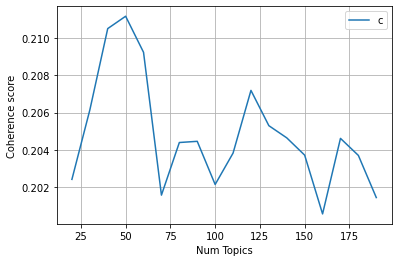

In [9]:
# Show graph
x = range(20,200,10)
plt.plot(x, NPMI)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Iteration 2 (Percise Investigation)

In [31]:
npmi = []
diversity = []

NPMI_2 = []
DIVERSITY_2 = []

for n in range(40,60,1):
    for i in range(3):
        result = evaluation(N_topics = n, CORPUS = CORPUS, all_words = all_words,
                   TOPK = TOPK , DATA = DATA, model = model , embeddings = embeddings)
        npmi.append(result["npmi"])
        diversity.append(result["diversity"])
    NPMI_2.append(np.mean(npmi))
    DIVERSITY_2.append(np.mean(diversity))
    npmi = []
    diversity = []

2022-08-08 23:07:49,327 - BERTopic - Reduced dimensionality with UMAP
2022-08-08 23:53:31,179 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-08 23:55:02,342 - BERTopic - Reduced number of topics from 666 to 41


Results
Topic number: 40
npmi: 0.21979253153875908
diversity: 0.63
 


2022-08-08 23:59:45,988 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 00:42:47,481 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 00:44:13,576 - BERTopic - Reduced number of topics from 649 to 41


Results
Topic number: 40
npmi: 0.20964642082077756
diversity: 0.6225
 


2022-08-09 00:48:49,266 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 01:31:56,058 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 01:33:25,601 - BERTopic - Reduced number of topics from 665 to 41


Results
Topic number: 40
npmi: 0.2136578925615419
diversity: 0.59
 


2022-08-09 01:38:12,885 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 02:21:31,039 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 02:23:05,343 - BERTopic - Reduced number of topics from 672 to 42


Results
Topic number: 41
npmi: 0.21574194769522476
diversity: 0.6195121951219512
 


2022-08-09 02:27:40,572 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 03:13:24,385 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 03:14:54,667 - BERTopic - Reduced number of topics from 668 to 42


Results
Topic number: 41
npmi: 0.21673988790265203
diversity: 0.624390243902439
 


2022-08-09 03:19:32,082 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 04:03:12,954 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 04:04:46,223 - BERTopic - Reduced number of topics from 686 to 42


Results
Topic number: 41
npmi: 0.21103584352674015
diversity: 0.624390243902439
 


2022-08-09 04:09:23,355 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 04:55:28,711 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 04:57:00,137 - BERTopic - Reduced number of topics from 671 to 43


Results
Topic number: 42
npmi: 0.22006920122219328
diversity: 0.611904761904762
 


2022-08-09 05:01:51,604 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 05:49:38,913 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 05:51:14,579 - BERTopic - Reduced number of topics from 693 to 43


Results
Topic number: 42
npmi: 0.22153800205940907
diversity: 0.6142857142857143
 


2022-08-09 05:55:57,611 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 06:40:56,464 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 06:42:29,184 - BERTopic - Reduced number of topics from 684 to 43


Results
Topic number: 42
npmi: 0.20832434878416117
diversity: 0.6238095238095238
 


2022-08-09 06:47:44,746 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 07:36:02,914 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 07:37:53,206 - BERTopic - Reduced number of topics from 662 to 44


Results
Topic number: 43
npmi: 0.20380465145935014
diversity: 0.6139534883720931
 


2022-08-09 07:43:29,181 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 08:42:42,282 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 08:44:13,876 - BERTopic - Reduced number of topics from 696 to 44


Results
Topic number: 43
npmi: 0.2129328291684921
diversity: 0.6255813953488372
 


2022-08-09 08:48:51,530 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 09:35:10,242 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 09:36:38,468 - BERTopic - Reduced number of topics from 661 to 44


Results
Topic number: 43
npmi: 0.20694065541034998
diversity: 0.627906976744186
 


2022-08-09 09:41:47,070 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 10:34:39,646 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 10:36:21,164 - BERTopic - Reduced number of topics from 674 to 45


Results
Topic number: 44
npmi: 0.21275524875396765
diversity: 0.634090909090909
 


2022-08-09 10:42:02,191 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 11:30:23,240 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 11:32:14,767 - BERTopic - Reduced number of topics from 668 to 45


Results
Topic number: 44
npmi: 0.20188139912756506
diversity: 0.634090909090909
 


2022-08-09 11:37:46,193 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 12:30:35,662 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 12:32:30,121 - BERTopic - Reduced number of topics from 676 to 45


Results
Topic number: 44
npmi: 0.20559422555827309
diversity: 0.615909090909091
 


2022-08-09 12:38:18,420 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 13:39:39,514 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 13:41:48,947 - BERTopic - Reduced number of topics from 692 to 46


Results
Topic number: 45
npmi: 0.20013561174193906
diversity: 0.6333333333333333
 


2022-08-09 13:48:26,856 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 14:45:19,076 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 14:47:17,411 - BERTopic - Reduced number of topics from 680 to 46


Results
Topic number: 45
npmi: 0.21814059598745214
diversity: 0.6133333333333333
 


2022-08-09 14:53:17,536 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 15:50:01,901 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 15:51:46,915 - BERTopic - Reduced number of topics from 687 to 46


Results
Topic number: 45
npmi: 0.20724653138001956
diversity: 0.6111111111111112
 


2022-08-09 15:57:09,216 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 16:45:55,732 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 16:47:35,852 - BERTopic - Reduced number of topics from 665 to 47


Results
Topic number: 46
npmi: 0.2257841606861572
diversity: 0.591304347826087
 


2022-08-09 16:52:48,138 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 17:45:05,783 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 17:46:47,022 - BERTopic - Reduced number of topics from 675 to 47


Results
Topic number: 46
npmi: 0.2071975204065333
diversity: 0.6391304347826087
 


2022-08-09 17:51:49,663 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 18:38:48,025 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 18:40:26,417 - BERTopic - Reduced number of topics from 657 to 47


Results
Topic number: 46
npmi: 0.21660765038372481
diversity: 0.5826086956521739
 


2022-08-09 18:45:39,644 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 19:36:05,532 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 19:37:45,161 - BERTopic - Reduced number of topics from 672 to 48


Results
Topic number: 47
npmi: 0.21084324623074846
diversity: 0.6
 


2022-08-09 19:42:52,085 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 20:33:30,759 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 20:35:09,192 - BERTopic - Reduced number of topics from 669 to 48


Results
Topic number: 47
npmi: 0.2101892827355485
diversity: 0.6127659574468085
 


2022-08-09 20:40:17,493 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 21:33:23,230 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 21:34:55,182 - BERTopic - Reduced number of topics from 687 to 48


Results
Topic number: 47
npmi: 0.2102574505797024
diversity: 0.6148936170212767
 


2022-08-09 21:39:50,037 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 22:28:52,673 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 22:30:25,606 - BERTopic - Reduced number of topics from 678 to 49


Results
Topic number: 48
npmi: 0.20915428847041295
diversity: 0.60625
 


2022-08-09 22:35:16,560 - BERTopic - Reduced dimensionality with UMAP
2022-08-09 23:18:29,746 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-09 23:19:58,136 - BERTopic - Reduced number of topics from 662 to 49


Results
Topic number: 48
npmi: 0.2132520845777893
diversity: 0.5979166666666667
 


2022-08-09 23:24:49,097 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 00:08:19,779 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 00:09:50,251 - BERTopic - Reduced number of topics from 678 to 49


Results
Topic number: 48
npmi: 0.2083701164979995
diversity: 0.6166666666666667
 


2022-08-10 00:14:41,401 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 00:57:56,926 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 00:59:24,215 - BERTopic - Reduced number of topics from 650 to 50


Results
Topic number: 49
npmi: 0.2095281202313322
diversity: 0.6142857142857143
 


2022-08-10 01:04:01,935 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 01:50:51,568 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 01:52:22,321 - BERTopic - Reduced number of topics from 679 to 50


Results
Topic number: 49
npmi: 0.21650547713786816
diversity: 0.6265306122448979
 


2022-08-10 01:57:07,606 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 02:40:11,893 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 02:41:41,908 - BERTopic - Reduced number of topics from 665 to 50


Results
Topic number: 49
npmi: 0.20888221159175477
diversity: 0.6122448979591837
 


2022-08-10 02:46:33,856 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 03:31:17,759 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 03:32:47,360 - BERTopic - Reduced number of topics from 667 to 51


Results
Topic number: 50
npmi: 0.20996595746750515
diversity: 0.604
 


2022-08-10 03:37:35,496 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 04:24:01,349 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 04:25:33,470 - BERTopic - Reduced number of topics from 691 to 51


Results
Topic number: 50
npmi: 0.21676026039280508
diversity: 0.6
 


2022-08-10 04:30:13,455 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 05:15:16,260 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 05:16:46,579 - BERTopic - Reduced number of topics from 677 to 51


Results
Topic number: 50
npmi: 0.20929433513884818
diversity: 0.596
 


2022-08-10 05:21:35,961 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 06:07:48,201 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 06:09:16,603 - BERTopic - Reduced number of topics from 672 to 52


Results
Topic number: 51
npmi: 0.21093429166522445
diversity: 0.596078431372549
 


2022-08-10 06:14:03,251 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 07:01:06,260 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 07:02:40,670 - BERTopic - Reduced number of topics from 685 to 52


Results
Topic number: 51
npmi: 0.20831928329896132
diversity: 0.592156862745098
 


2022-08-10 07:07:33,891 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 07:53:19,100 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 07:54:50,408 - BERTopic - Reduced number of topics from 669 to 52


Results
Topic number: 51
npmi: 0.21957966390898315
diversity: 0.6098039215686275
 


2022-08-10 07:59:35,666 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 08:49:57,857 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 08:51:35,526 - BERTopic - Reduced number of topics from 686 to 53


Results
Topic number: 52
npmi: 0.2064668126344442
diversity: 0.6057692307692307
 


2022-08-10 08:57:07,788 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 09:49:30,733 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 09:51:09,884 - BERTopic - Reduced number of topics from 670 to 53


Results
Topic number: 52
npmi: 0.20816142152086595
diversity: 0.5923076923076923
 


2022-08-10 09:57:32,469 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 10:46:16,182 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 10:47:58,504 - BERTopic - Reduced number of topics from 674 to 53


Results
Topic number: 52
npmi: 0.2104264886236392
diversity: 0.5961538461538461
 


2022-08-10 10:53:28,489 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 11:44:30,218 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 11:46:06,309 - BERTopic - Reduced number of topics from 688 to 54


Results
Topic number: 53
npmi: 0.21357709956953289
diversity: 0.6075471698113207
 


2022-08-10 11:51:07,441 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 12:40:19,751 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 12:41:58,718 - BERTopic - Reduced number of topics from 684 to 54


Results
Topic number: 53
npmi: 0.20971128980889606
diversity: 0.5867924528301887
 


2022-08-10 12:47:52,664 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 13:33:45,372 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 13:35:16,998 - BERTopic - Reduced number of topics from 671 to 54


Results
Topic number: 53
npmi: 0.20665102804571983
diversity: 0.5962264150943396
 


2022-08-10 13:40:07,837 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 14:24:00,342 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 14:25:37,154 - BERTopic - Reduced number of topics from 668 to 55


Results
Topic number: 54
npmi: 0.20447530777386227
diversity: 0.6
 


2022-08-10 14:30:37,214 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 15:14:06,738 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 15:15:42,836 - BERTopic - Reduced number of topics from 673 to 55


Results
Topic number: 54
npmi: 0.20679343637193343
diversity: 0.5833333333333334
 


2022-08-10 15:20:41,471 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 16:04:44,662 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 16:06:18,807 - BERTopic - Reduced number of topics from 676 to 55


Results
Topic number: 54
npmi: 0.20790833695268363
diversity: 0.6037037037037037
 


2022-08-10 16:11:20,920 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 16:54:22,606 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 16:56:02,283 - BERTopic - Reduced number of topics from 673 to 56


Results
Topic number: 55
npmi: 0.21180525046905818
diversity: 0.6090909090909091
 


2022-08-10 17:00:51,203 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 17:43:15,799 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 17:44:46,808 - BERTopic - Reduced number of topics from 671 to 56


Results
Topic number: 55
npmi: 0.21719854063414862
diversity: 0.5836363636363636
 


2022-08-10 17:49:46,653 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 18:31:01,341 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 18:32:28,919 - BERTopic - Reduced number of topics from 669 to 56


Results
Topic number: 55
npmi: 0.19891229929610513
diversity: 0.6054545454545455
 


2022-08-10 18:37:22,492 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 19:19:41,326 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 19:21:12,744 - BERTopic - Reduced number of topics from 687 to 57


Results
Topic number: 56
npmi: 0.20845137869384558
diversity: 0.6035714285714285
 


2022-08-10 19:26:00,796 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 20:12:05,488 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 20:13:36,680 - BERTopic - Reduced number of topics from 690 to 57


Results
Topic number: 56
npmi: 0.20261907232876084
diversity: 0.5982142857142857
 


2022-08-10 20:18:21,430 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 21:00:38,041 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 21:02:07,687 - BERTopic - Reduced number of topics from 673 to 57


Results
Topic number: 56
npmi: 0.20717983451103333
diversity: 0.5928571428571429
 


2022-08-10 21:06:47,579 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 21:47:34,168 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 21:49:03,997 - BERTopic - Reduced number of topics from 672 to 58


Results
Topic number: 57
npmi: 0.20891077855165105
diversity: 0.6105263157894737
 


2022-08-10 21:53:26,313 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 22:34:37,374 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 22:36:06,290 - BERTopic - Reduced number of topics from 663 to 58


Results
Topic number: 57
npmi: 0.21301803591669513
diversity: 0.5789473684210527
 


2022-08-10 22:40:54,313 - BERTopic - Reduced dimensionality with UMAP
2022-08-10 23:25:00,110 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-10 23:26:30,245 - BERTopic - Reduced number of topics from 678 to 58


Results
Topic number: 57
npmi: 0.20946459492857744
diversity: 0.5842105263157895
 


2022-08-10 23:31:06,570 - BERTopic - Reduced dimensionality with UMAP
2022-08-11 00:10:25,808 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-11 00:11:58,721 - BERTopic - Reduced number of topics from 688 to 59


Results
Topic number: 58
npmi: 0.21390267002935878
diversity: 0.5741379310344827
 


2022-08-11 00:16:52,973 - BERTopic - Reduced dimensionality with UMAP
2022-08-11 01:00:03,122 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-11 01:01:34,371 - BERTopic - Reduced number of topics from 677 to 59


Results
Topic number: 58
npmi: 0.2102784743445752
diversity: 0.5706896551724138
 


2022-08-11 01:06:25,732 - BERTopic - Reduced dimensionality with UMAP
2022-08-11 01:48:36,545 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-11 01:50:05,699 - BERTopic - Reduced number of topics from 658 to 59


Results
Topic number: 58
npmi: 0.20864205017360954
diversity: 0.5948275862068966
 


2022-08-11 01:54:49,348 - BERTopic - Reduced dimensionality with UMAP
2022-08-11 02:36:51,049 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-11 02:38:21,809 - BERTopic - Reduced number of topics from 669 to 60


Results
Topic number: 59
npmi: 0.21518487459420302
diversity: 0.5779661016949152
 


2022-08-11 02:43:09,318 - BERTopic - Reduced dimensionality with UMAP
2022-08-11 03:29:14,974 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-11 03:30:49,638 - BERTopic - Reduced number of topics from 701 to 60


Results
Topic number: 59
npmi: 0.20498399507760365
diversity: 0.5898305084745763
 


2022-08-11 03:35:45,420 - BERTopic - Reduced dimensionality with UMAP
2022-08-11 04:20:36,722 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-08-11 04:22:09,301 - BERTopic - Reduced number of topics from 682 to 60


Results
Topic number: 59
npmi: 0.20970941038750024
diversity: 0.6
 


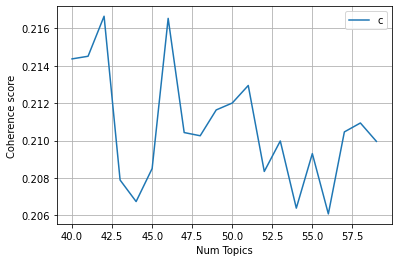

In [32]:
# Show graph
x = range(40,60,1)
plt.plot(x, NPMI_2)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Optimal number of topics

In [41]:
num = 40
for i in NPMI_2:
    print("Number: "+str(num))
    print("CV: "+str(i))
    if i == max(NPMI_2):
        print("This is the best!!!!!!!!!!!!!!!")
        best = (num,i)
    num+=1

Number: 40
CV: 0.21436561497369286
Number: 41
CV: 0.21450589304153897
Number: 42
CV: 0.21664385068858785
This is the best!!!!!!!!!!!!!!!
Number: 43
CV: 0.20789271201273074
Number: 44
CV: 0.20674362447993525
Number: 45
CV: 0.20850757970313694
Number: 46
CV: 0.21652977715880514
Number: 47
CV: 0.2104299931819998
Number: 48
CV: 0.21025882984873392
Number: 49
CV: 0.21163860298698503
Number: 50
CV: 0.21200685099971947
Number: 51
CV: 0.212944412957723
Number: 52
CV: 0.20835157425964979
Number: 53
CV: 0.20997980580804962
Number: 54
CV: 0.2063923603661598
Number: 55
CV: 0.20930536346643733
Number: 56
CV: 0.20608342851121328
Number: 57
CV: 0.2104644697989745
Number: 58
CV: 0.21094106484918118
Number: 59
CV: 0.20995942668643564


In [42]:
best

(42, 0.21664385068858785)

## Evaluate Optimized Model

#### Model Creation


Create and save model **(DON'T RUN)**

In [11]:
optimal_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, 
                         diversity = None,embedding_model= "all-mpnet-base-v2", min_topic_size = 15, 
                         nr_topics= 42)
optimal_model.save("BERTmodel_39")
topics, probs = optimal_model.fit_transform(DATA, embeddings)

2022-10-20 18:58:01,273 - BERTopic - Reduced dimensionality with UMAP
2022-10-20 19:31:30,411 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-10-20 19:33:02,851 - BERTopic - Reduced number of topics from 637 to 43


Loading Trained Model (RUN)

In [48]:
# Import model21
optimal_model = BERTopic.load("BERTmodel_39")
# Import embeddings
embeddings = loadtxt('embeddings.csv', delimiter=',')
# Modeling
topics, probs = optimal_model.fit_transform(DATA, embeddings)

2022-10-21 12:31:31,361 - BERTopic - Reduced dimensionality with UMAP
2022-10-21 13:09:40,482 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-10-21 13:11:14,394 - BERTopic - Reduced number of topics from 647 to 43


#### Topic Word List

In [32]:
freq = optimal_model.get_topic_info(); freq

,Topic,Count,Name
0,-1,102468,-1_fire_home_fall_injury
1,0,5771,0_bicyclist_bicycle_scooter_vehicle
2,1,3934,1_drown_death_autopsy_manner
3,2,3448,2_ladder_fall_stair_head
4,3,3355,3_electrical_extension_cord_fire_space_heater
5,4,3098,4_apartment_candle_fire_stove
6,5,3015,5_toy_battery_mouth_laptop
7,6,2971,6_terrain_vehicle_golf_cart_autopsy_injury
8,7,2822,7_fire_house_firefighter_window
10,8,2625,8_nan_apneic_yet_fine


#### Visulazation

In [33]:
optimal_model.visualize_topics()

#### Topic Distribution within a single text

In [34]:
optimal_model.visualize_distribution(probs[0], min_probability= 0.01)#0.015)

#### Hierachical Structure of Topics
We can merge some topics into a single topic

In [35]:
 optimal_model.visualize_hierarchy(top_n_topics=921)

#### Word element distribution within topics

In [36]:
optimal_model.visualize_barchart(top_n_topics=42)

#### Similar Matrix

In [19]:
optimal_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

#### Topic representation

In [37]:
optimal_model.visualize_term_rank()

#### Detect topic related to specific key word
Searching topic related to specific key word

In [38]:
similar_topics, similarity = optimal_model.find_topics("coffee", top_n=5); similar_topics

[7, -1, 16, 19, 22]

In [39]:
optimal_model.get_topic(8)

[('nan', 3.3968904109598803),
 ('apneic', 0.003489591625441188),
 ('yet', 0.003059526265446847),
 ('fine', 0.0016029931954101527),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05)]

#### Output Topic Words List (DON'T RUN)

In [40]:
# import openpyxl
# Topic_Word_List = pd.DataFrame(columns=['Topic_Number', 'Word_1','Word_1_percentage', 
#                                               'Word_2','Word_2_percentage','Word_3','Word_3_percentage',
#                                               'Word_4','Word_4_percentage', 'Word_5','Word_5_percentage', 
#                                               'Word_6','Word_6_percentage','Word_7','Word_7_percentage',
#                                               'Word_8','Word_8_percentage','Word_9','Word_9_percentage',
#                                               'Word_10','Word_10_percentage'])
# for i in range(0,42):
#     Topic_Word_List = Topic_Word_List.append({'Topic_Number':i,
#                                               'Word_1':optimal_model.get_topic(i)[0][0], 
#                                                'Word_1_percentage':optimal_model.get_topic(i)[0][1],
#                                                'Word_2':optimal_model.get_topic(i)[1][0],
#                                                'Word_2_percentage':optimal_model.get_topic(i)[1][1],
#                                                'Word_3':optimal_model.get_topic(i)[2][0],
#                                                'Word_3_percentage':optimal_model.get_topic(i)[2][1],
#                                                'Word_4':optimal_model.get_topic(i)[3][0],
#                                                'Word_4_percentage':optimal_model.get_topic(i)[3][1], 
#                                                'Word_5':optimal_model.get_topic(i)[4][0],
#                                                'Word_5_percentage':optimal_model.get_topic(i)[4][1], 
#                                                'Word_6':optimal_model.get_topic(i)[5][0],
#                                                'Word_6_percentage':optimal_model.get_topic(i)[5][1],
#                                                'Word_7':optimal_model.get_topic(i)[6][0],
#                                                'Word_7_percentage':optimal_model.get_topic(i)[6][1],
#                                                'Word_8':optimal_model.get_topic(i)[7][0],
#                                                'Word_8_percentage':optimal_model.get_topic(i)[7][1],
#                                                'Word_9':optimal_model.get_topic(i)[8][0],
#                                                'Word_9_percentage':optimal_model.get_topic(i)[8][1],
#                                                'Word_10':optimal_model.get_topic(i)[9][0],
#                                                'Word_10_percentage':optimal_model.get_topic(i)[9][1]},
#                                                 ignore_index=True)
# 
# 
# Topic_Word_List.to_excel("../Result/BERTopic_Topic_Word_List_topics_FINAL.xlsx", 
#                          header = True, index = False)

## Dynamic Topic Model

#### Take date into account

In [41]:
dates = list(df["Year"])

#### Train Dynamic Model

In [42]:
topics_over_time = optimal_model.topics_over_time(docs=DATA, 
                                                topics=topics, 
                                                timestamps=dates, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=30)

7it [00:04,  1.65it/s]


#### Topic popularity Visualization

In [43]:
g1 = [6,29,28,1,20,33]
g2 = [5, 41, 15, 0, 10]
g3 = [25, 34, 27, 39, 8, 37, 21, 7, 16]
g4 = [3]
g5 = [30, 13, 2, 17, 11, 40, 4, 38, 32, 18, 23]
g6 = [35, 19, 26, 14, 24]
g7 = [9, 22]
g8 = [36, 12, 31]

In [44]:
optimal_model.visualize_topics_over_time(topics_over_time, 
                                         topics = g8)


#### Global Keywords representation

In [45]:
optimal_model.visualize_hierarchy(top_n_topics=921)

In [46]:
optimal_model.get_topic(0)

[('bicyclist', 0.11160329571588962),
 ('bicycle', 0.09509836350731111),
 ('scooter', 0.08393866022059748),
 ('vehicle', 0.0745058810821003),
 ('car', 0.07317273736506064),
 ('ride', 0.0682136354345397),
 ('strike', 0.06397527772036082),
 ('hit', 0.062364145645772036),
 ('driver', 0.0580303330235805),
 ('hospital', 0.05282800641070144)]

#### Topic keywords representation in each year

In [47]:
topics_over_time[topics_over_time["Topic"]
                 ==0].sort_values("Timestamp")["Words"]

1         bicycle, bicyclist, ride, car, scooter
44        bicycle, bicyclist, scooter, car, ride
87        bicyclist, scooter, bicycle, car, ride
130    bicyclist, scooter, bicycle, car, vehicle
173    bicyclist, bicycle, scooter, car, vehicle
216    bicyclist, bicycle, vehicle, scooter, car
259    bicyclist, bicycle, vehicle, strike, ride
Name: Words, dtype: object

In [ ]:
hang, autopsy, asphyxia, bag, suffocation
hang, autopsy, bag, suffocation, decedent
hang, autopsy, bag, suffocation, decedent
hang, autopsy, asphyxiation, bag, suffocation
hang, autopsy, bag, suffocation, decedent
hang, autopsy, suffocation, bag, decedent
hang, autopsy, suffocation, asphyxiation, bag
hang, autopsy, bag, suffocation, asphyxiation

#### Topic text representation

In [180]:
optimal_model.get_representative_docs(27)[5:10]

['decedent fall death head fall autopsy',
 'decedent fall home atherosclerosis autopsy',
 'decedent fall home fall autopsy',
 'decedent fall home fall autopsy',
 'decedent die home autopsy']

In [89]:
DATA[1]

'helmet sell online as_well rate world govern body ski racing fis rating competitive skiing globally experienced user various helmet wear life ski racer rider high performance jet pilot helmet secure head chin_strap helmet adjust correct tension loose ski mean helmet secure event mishap purpose helmet protect head mishap stop partially ski_slope adjust correct tension flaw manufacturer responsive claim understand photo purchaser helmet risk helmet wear life helmet ever flaw fit purpose'

In [88]:
optimal_model.get_topic(31)

[('rash', 0.10707764951728915),
 ('diaper', 0.07858551116997073),
 ('wrist', 0.06803132845897562),
 ('wear', 0.05399213761513745),
 ('fitbit', 0.05384745455990853),
 ('skin', 0.04684099027340772),
 ('blister', 0.034591028374350664),
 ('red', 0.03267534381430852),
 ('watch', 0.03164159266914075),
 ('band', 0.03144369176862893)]

In [124]:
optimal_model.find_topics('personal injury')

([5, 7, 41, -1, 8],
 [0.48995840336298657,
  0.478192910869601,
  0.47406028980648485,
  0.46145445874438545,
  0.4528950413392855])

In [188]:
df[df["Topic_number"]==27]["Description"][78714]

'a 73 yof decedent died in a sauna undetermined natural causes in a hot environment autopsy unknown'

## Save Model (DON'T RUN)

In [247]:
df["Topic_number"]="NA"
for i in range(78976,len(df["Topic_number"])):
    df["Topic_number"][i] = optimal_model.find_topics(DATA[i]) [0] [0]
    

In [248]:
df.to_excel("USCA_final.xlsx", header = True, index = False)

#### Save Model

In [234]:
# optimal_model.save("BERTmodel")

/Users/hanjunwei/Desktop/UL/ul_env/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

